In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

# Read in Data

In [31]:
data_dir = r'../data/'

data = pd.DataFrame()

for entry in os.scandir(data_dir):
    if (entry.path.endswith('.json') and entry.is_file()):
        if data.empty:
            data = pd.read_json(entry.path)
        else:
            entry_data = pd.read_json(entry.path)
            data = pd.concat([data, entry_data], ignore_index=True)

# Data Clean-up

In [32]:
# For all of these, see explanations below.

# Remove duplicates
data.drop_duplicates(subset ="post_id", 
                     keep = "last", inplace = True)

# Things deemed not important:
# fuel, VIN, drive, size, type
data.drop(['cylinders', 'VIN', 'drive', 'size', 'type', 'fuel','paint color','condition'],
          axis=1, inplace=True)
# Remove listings that have a null "brand". Reason: It is ~5% missing, and brand is important to 
# categorize
data = data[data['brand'].notna()]
# Remove salvage vehicles.
# data = data[data['condition'] != 'salvage']

# Change odometer inputs to thousands
data['odometer'] = np.where((data['odometer'] < 1000.0) & (data['year'] < 2018),
                           data['odometer'] * 1000,
                           data['odometer'])

# !! TO CHANGE:
# Remove values with odometer = 0 below the year 2018
# CHANGE IT TO NA INSTEAD OF 0 OR FALSE. Deal with null values of odometer
data.drop(data[data['odometer'] == False][data['year'] <= 2018].index, inplace=True)

# Remove edge case where a certain salesman sets odometer to "1"
data.drop(data[data['odometer'] == 1].index, inplace=True)

# Remove entries with no model data
data.drop(data[data['model'] == ''].index, inplace=True)


data.shape

C:\Users\justi\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(3118, 9)

### Why did I drop ['cylinders', 'VIN', 'drive', 'size', 'type', 'fuel', 'condition', 'paint color']?

In [33]:
# Things deemed not important:
# cylinders, fuel, VIN, drive, size, type, fuel
# These categories generally stay the same within the same model.
# Rarely will you see different values within the same model, but when you do,
# there is but a small change in price. We want to focus on the most important
# factors, rather than the miniscule.
# VIN is unique to every vehicle.

# To add onto that, see the data below of missing values.
# Above 25% missing: Cylinders, VIN, drive, size, type, paint color
# For cylinders, VIN, drive, size and type, we will remove the columns as a whole. These aren't important
# in the grand scheme of things, because when a vehicle is searched, it's assumed these are constant for that model 
# (except VIN).

# Paint color: There is very very little affect on price based on paint color.
# Considering paint having an issue of 33% missing, this poses a problem.
# The column will be removed.

# Condition: Condition is subjective.
# Unless salvaged, which I assume will be marked, there is very little difference.

# Check NA (percentage missing):
data.isnull().sum() *100 / len(data)

post_id          0.000000
brand            0.000000
url              0.000000
price            0.000000
year             0.000000
model            0.000000
odometer        20.814625
title status     0.000000
transmission     0.000000
dtype: float64

In [34]:
# Problems to deal with:

#-----------------------------------------------

# What should we do about the rest of our missing data?
# Well, if we drop all na, then we are left with about only half of the data. 
# That won't be good.
# data.dropna().shape

#-----------------------------------------------

# people love to put the odometer, in kms, instead of a full amount. (eg if it's at 150,000 kms, they just put 150)

# data[data['odometer'] == 200.0]
# you can see that these vehicles are all older, and are definitely not only 200 kms driven.
# 200,000 sounds about right.

# data['odometer'] = np.where((data['odometer'] < 1000.0) & (data['year'] < 2018),
#                            data['odometer'] * 1000,
#                            data['odometer'])

# If you run a quick "data[data['odometer'] < 1000]", everything looks about right.

#-----------------------------------------------

# Remove all vehicles with odometer = 0 and year <= 2018.

# data.drop(data[data['odometer'] == False][data['year'] <= 2018].index, inplace=True)

# Odometer is a critical part in deciding the price of a vehicle.
# In data size, we aren't missing out on much if we just remove these entries.
# As I am writing this, out of 2598 entries, only 1 satisfies this.

#-----------------------------------------------

# There's a specific bmw salesman who likes to post ads with an odometer of 1, regardless of actual odometer.
# This really messes with the data.
# Let's remove their entries. They're not that many.
# Ads with a "1" odometer don't really mean it has 1 km on it, either.

# data.drop(data[data['odometer'] == 1].index, inplace=True)

#-----------------------------------------------

# There's a decent amount of data that has model = "". We need to get rid of those, as they
# won't be useful in determining model price if there is no model.

# data.drop(data[data['model'] == ''].index, inplace=True)

data.shape

#-----------------------------------------------

(3118, 9)

In [36]:
# How are we going to use "model" consistently? Do we mix all "civic" together? (eg civic sport, civic coupe, civic touring..)

data[data['odometer'].isnull()]

,post_id,brand,url,price,year,model,odometer,title status,transmission
10,7125260321,chevrolet,https://vancouver.craigslist.org/rch/cto/d/ric...,4200,2005,astro van,NaN,clean,automatic
20,7118753617,mazda,https://vancouver.craigslist.org/nvn/cto/d/nor...,4400,2003,protege,NaN,clean,automatic
21,7126438735,ford,https://vancouver.craigslist.org/nvn/cto/d/nor...,500,1999,1999 escape,NaN,clean,automatic
27,7115507159,toyota,https://vancouver.craigslist.org/van/cto/d/bur...,2400,1997,camry,NaN,clean,automatic
31,7119289211,mercedes-benz,https://vancouver.craigslist.org/van/cto/d/sur...,4200,2002,benz,NaN,clean,automatic
...,...,...,...,...,...,...,...,...,...
5252,7135320981,chevrolet,https://vancouver.craigslist.org/rds/ctd/d/bur...,27900,2019,equinox,NaN,clean,automatic
5262,7135304042,jaguar,https://vancouver.craigslist.org/van/ctd/d/gab...,44888,2016,xj,NaN,clean,automatic
5270,7135305259,mercedes-benz,https://vancouver.craigslist.org/van/ctd/d/gab...,44888,2016,gle 350 4matic,NaN,clean,automatic
5277,7135299060,ford,https://vancouver.craigslist.org/rds/cto/d/lan...,18500,2001,f350 super duty,NaN,clean,automatic


# Plot and Visualize

Text(0.5, 0, 'count')

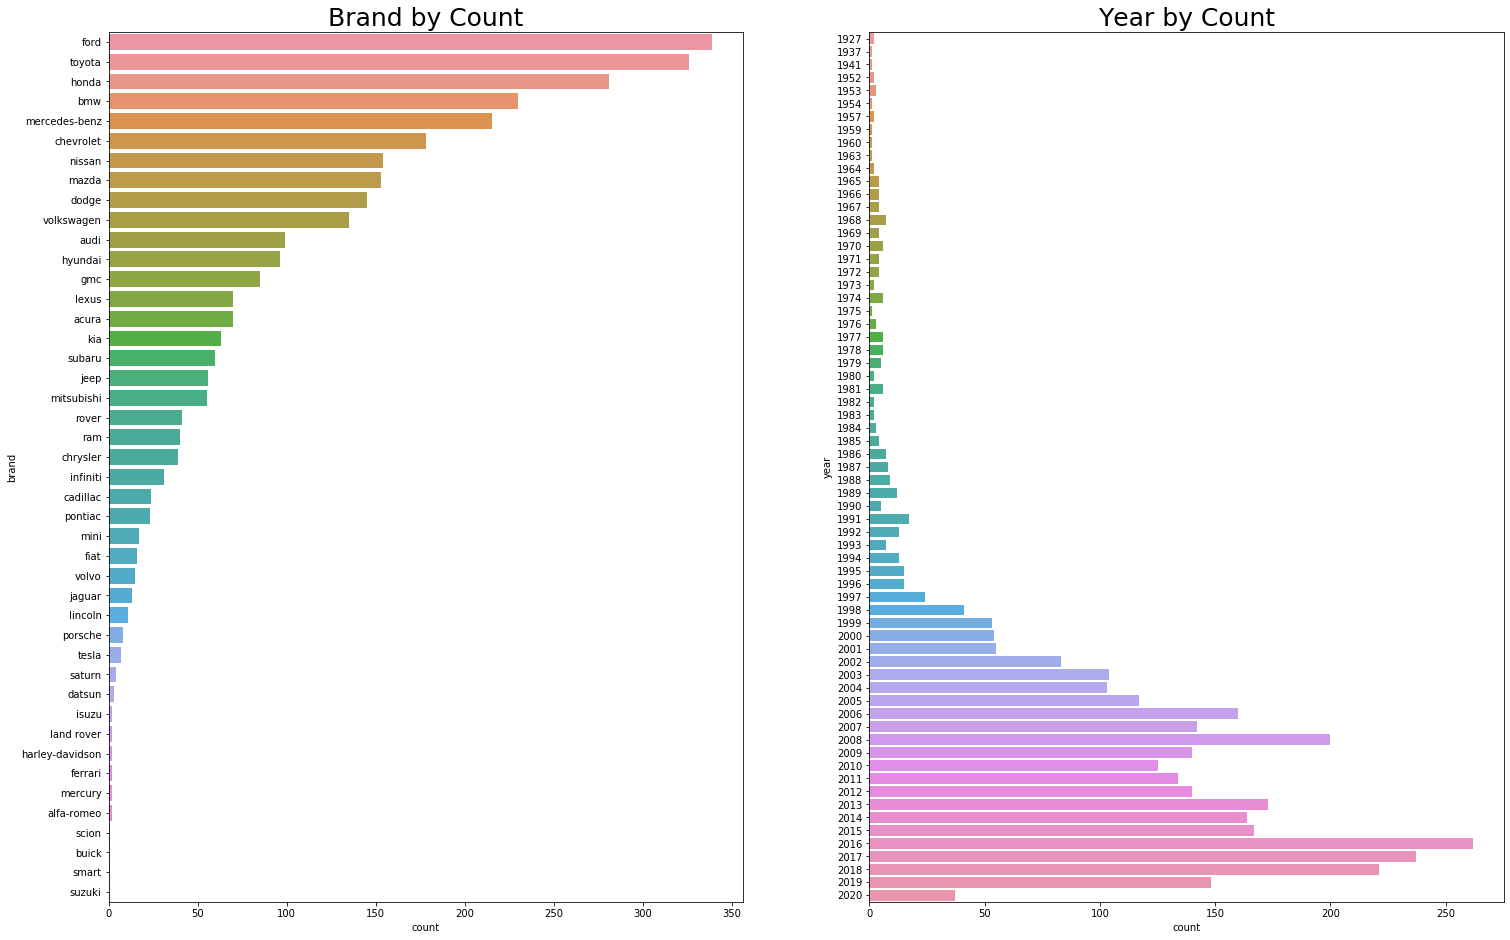

In [7]:
fig, axes = plt.subplots(1,2,figsize=(25,16))

(sns.barplot(y=data.brand.value_counts().index, x=data.brand.value_counts(), orient='h',ax=axes[0])
 .set_title('Brand by Count',fontsize=25))
axes[0].set_ylabel('brand')
axes[0].set_xlabel('count')
(sns.barplot(y=data.year.value_counts().index, x=data.year.value_counts(), orient='h',ax=axes[1])
 .set_title('Year by Count',fontsize=25))
axes[1].set_ylabel('year')
axes[1].set_xlabel('count')

Text(0, 0.5, '')

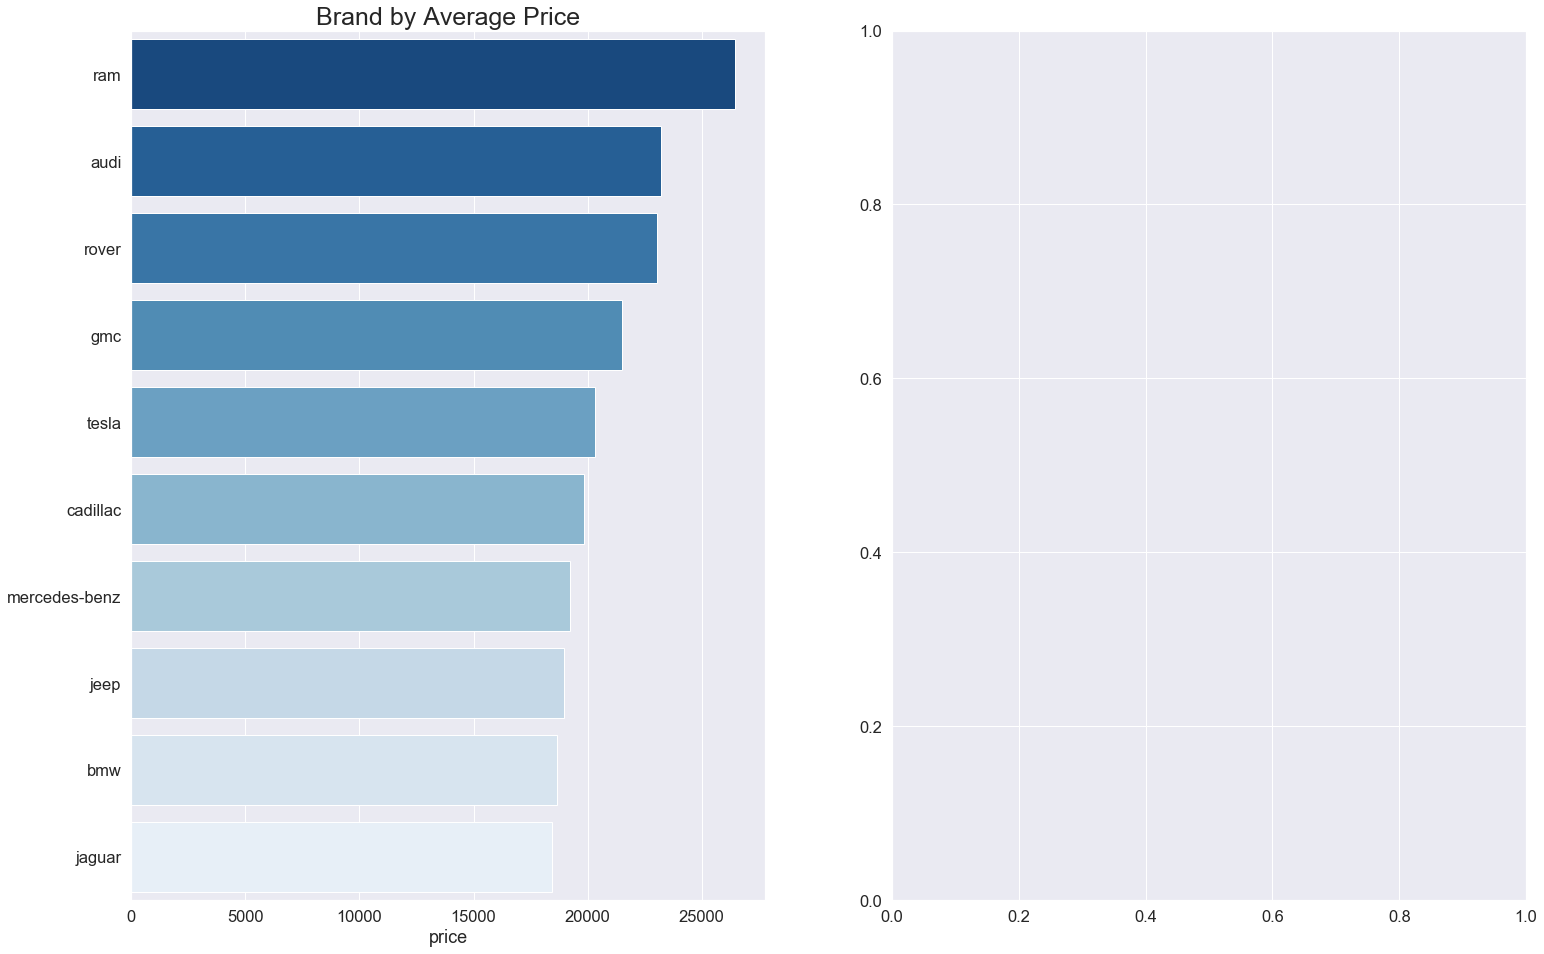

In [60]:
def bayes_avg(df,cond,col):
    """
    This function was taken from Heidi Jiang's "New Porkers" project
    See: https://github.com/heidijiang/new-porkers/
    
    """
    v = df.groupby(cond)[col].size()
    m = df[cond].value_counts().mean()
    w = v/(v+m)
    S = w*df.groupby(cond)[col].mean() + (1-w)*df[col].mean()
    return S

pr = (bayes_avg(data.dropna(how='any'), 'brand', 'price').sort_values(ascending=False)
     .reset_index().sort_values('price', ascending=False))
pr = pr.iloc[:10]

pr

fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette(sns.cubehelix_palette(8))

sns.set(font_scale = 1.5)

sns.barplot(data=pr,x='price',y='brand',orient='h',ax=axes[0], palette="Blues_r").set_title('Brand by Average Price', fontsize=25)
axes[0].set_ylabel('')